In [67]:
import numpy as np
import random 
import torch
import database as db
import identify as idt
from torch import tensor
import numpy as np
import torch.nn as nn
from torch.nn import Conv2d
from torch.nn.functional import cross_entropy
#from torch.nn import ReLU
from torch.optim import Adam
softmax = nn.functional.softmax
from pathlib import Path
import pickle


In [56]:
ReLU = nn.functional.relu

In [8]:
import model
from noggin import create_plot

In [89]:
class Pill_Model(nn.Module):

    def __init__(self, input_shape): #note the first dim will be 3, for 3 color channels
        """ 
        Initializes layers in  model, and sets them 
        as attributes of model.

        Parameters
        -------------------
        input_shape : List representing image 
        """
        super().__init__()
        # data in shape of N x 256 x 256 x 3 (N = # of photos)
        self.conv1 = Conv2d(in_channels=input_shape[0], out_channels=8, kernel_size=(7, 7), stride=1)
        self.conv2 = Conv2d(in_channels=8, out_channels=16, kernel_size=7, stride=1)
        self.conv3 = Conv2d(in_channels=16, out_channels=32, kernel_size=7, stride=1)
        self.batchnorm1 = nn.BatchNorm2d(num_features=8)
        self.batchnorm2 = nn.BatchNorm2d(num_features=16)
        self.batchnorm3 = nn.BatchNorm2d(num_features=32)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.dense = nn.Linear(in_features = 21632, out_features = 5, bias=False)

        for m in (self.conv1, self.conv2, self.conv3, self.dense):   #converts from default weight normalization to glorot(xavier)
            #nn.init.constant_(m.bias,0)
            nn.init.xavier_normal_(m.weight, np.sqrt(2))
        
    def __call__(self, x):
        '''Passes data as input to our model, performing a "forward-pass".
        
        This allows us to conveniently initialize a model `m` and then send data through it
        to be classified by calling `m(x)`.

        Model 
        
        Parameters
        ----------
        x : An array of image descriptor vectors?
        Returns
        -------
        self.maxpool(ReLU(self.conv3(pass3))))
        return self.dense(pass3)
        '''
        # TODO : incorporate more layers if needed

        pass1 = self.batchnorm1(self.maxpool(ReLU(self.conv1(x.float()))))
        pass2 = self.batchnorm2(self.maxpool(ReLU(self.conv2(pass1.float()))))
        pass3 = self.batchnorm3(self.maxpool(ReLU(self.conv3(pass2.float()))))
        #print(pass3.shape)
        pass3 = torch.reshape(pass3, (32, 21632))
        print(pass3.shape)
        #do sofsoftmax(tmax on the final) result to get the probability distribution
        return softmax(self.dense(pass3))

        
    @property
    def parameters(self):
        """ A convenience function for getting all the parameters of our model.
        
        This can be accessed as an attribute, via `model.parameters` 
        conv1 + self.conv2..parameters + self.conv3 +.parameters
        Returns
        -------
        Tuple[Tensor, ...]
            A tuple containing all of the learnable parameters for our model """
        # STUDENT CODE HERE
        return list(self.conv1.parameters()) + list(self.conv2.parameters()) + list(self.conv3.parameters())

In [164]:
def accuracy(output, target):
    '''
    Calculates accuracy of model, defined by percentage of classifications equal to truth
    
    Parameters
    ----------
    output (shape M x N) : 

    target (shape M x N) : 
    
    Returns
    -------
    mygrad.Tensor, shape=(200,)
        The model's embedded image vectors
    '''
    print(np.argmax(output, axis = 1))
    print(target)
    return np.mean(np.argmax(output, axis = 1) == target)

In [166]:
%matplotlib notebook

<IPython.core.display.Javascript object>


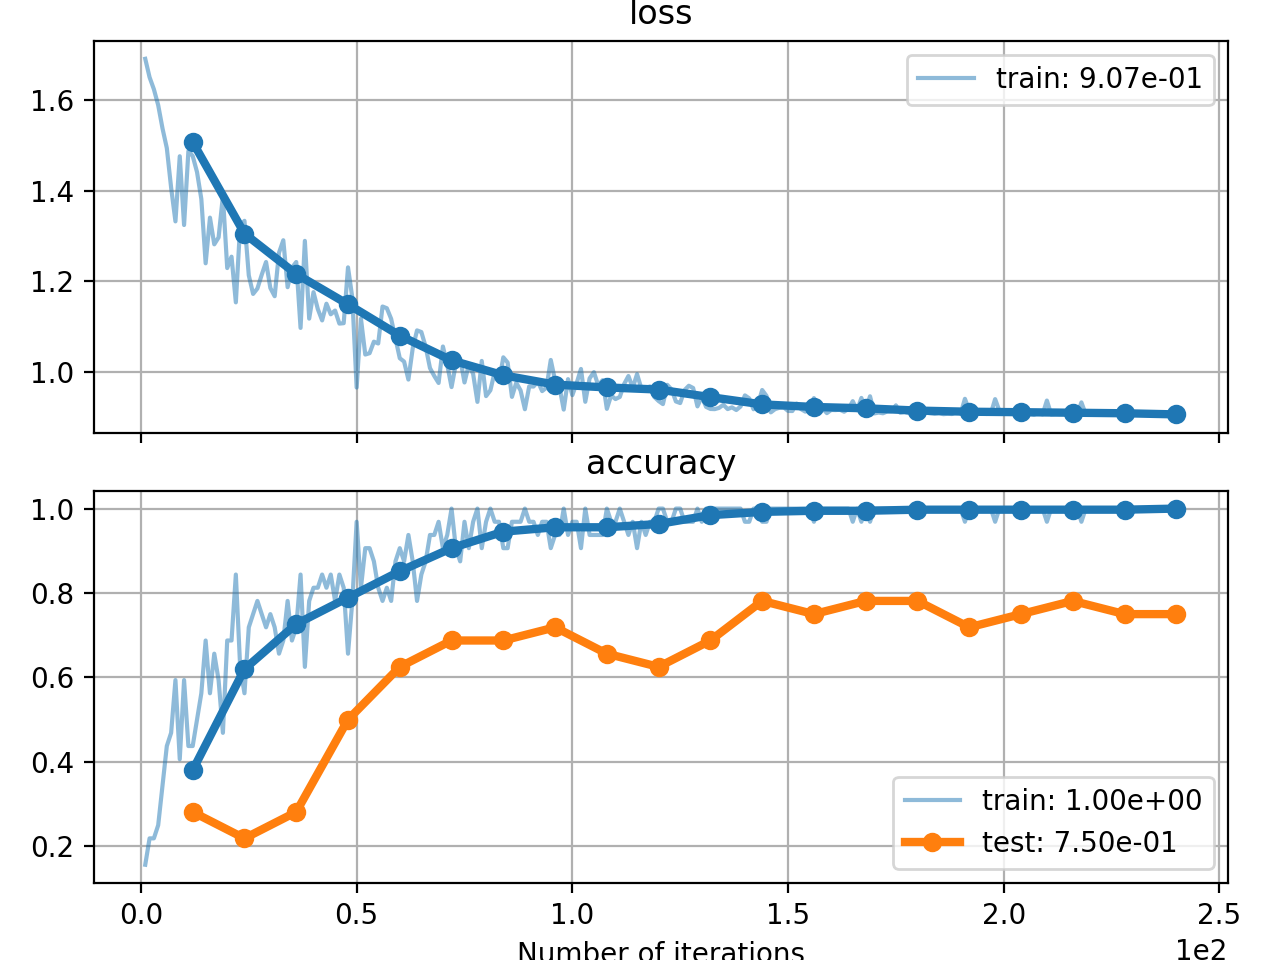

In [167]:
plotter, fig, ax = create_plot(["loss", "accuracy"])

In [169]:
model=Pill_Model((3, 256, 256))

optim = Adam(model.parameters, weight_decay=14e-3)

<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.linear.Linear'>


In [171]:
num_epochs = 10#define num_epochs
#train_data is for all images, pill_name is corresponding label for each pill image
db.load_images()
num_imgs = len(db.imgs)

train_data = np.array(db.imgs[:(num_imgs * 9 // 10), 0])
train_names = db.imgs[:(num_imgs * 9 // 10), 1]

test_data = db.imgs[(num_imgs * 9 // 10):, 0]
test_names = db.imgs[(num_imgs * 9 // 10):, 1]

batch_size= 32 #define this as well
for epoch_cnt in range(0,num_epochs):
    idxs = np.arange(len(train_data))  
    np.random.shuffle(idxs)  
    
    for batch_cnt in range(0, len(train_data)//batch_size):
        batch_indices = idxs[batch_cnt*batch_size : (batch_cnt + 1)*batch_size]
        batch = [train_data[i] for i in batch_indices]  # random batch of our training data
        batch = torch.tensor(np.reshape(np.stack(batch), (32, 3, 256, 256)))
        truth = torch.argmax(torch.tensor(db.get_one_hot(train_names[batch_indices])), dim = 1)
        optim.zero_grad()
        prediction = model(batch) 
        
        loss = cross_entropy(prediction, truth)
        loss.backward()
        optim.step()
        acc = accuracy(prediction.detach().numpy(), truth.detach().numpy())
        plotter.set_train_batch({"accuracy": acc, "loss" : loss.item()},  batch_size=batch_size)
    for batch_cnt in range(0, len(test_data) // batch_size):
        idxs = np.arange(len(test_data))
        batch_indices = batch_indices = idxs[batch_cnt*batch_size : (batch_cnt + 1)*batch_size]#  get the batch of our **test** data
        batch = [test_data[i] for i in batch_indices]#  get the batch of our **test** labels
        batch = torch.tensor(np.reshape(np.stack(batch), (32, 3, 256, 256)))

        with torch.no_grad():
            # get your model's prediction on the test-batch
            prediction = model(batch)#

            # get the truth values for that test-batch
            truth = torch.argmax(torch.tensor(db.get_one_hot(test_names[batch_indices])), dim = 1)#

            # compute the test accuracy
            acc = accuracy(prediction.detach().numpy(), truth.detach().numpy())#

        # log the test-accuracy in noggin
        plotter.set_test_batch({"accuracy": acc}, batch_size=batch_size)

    plotter.set_train_epoch()
    plotter.set_test_epoch()
plotter.plot()

torch.Size([32, 21632])


/var/folders/12/7wfxv5811h33zvry6tpz0kw40000gn/T/ipykernel_2625/1105441521.py:53: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return softmax(self.dense(pass3))


[0 2 0 1 0 3 1 0 3 3 0 3 0 0 3 4 3 2 3 4 2 2 1 0 2 0 1 0 2 4 1 2]
[0 2 0 1 0 3 1 0 3 3 0 3 0 0 3 4 3 2 3 4 2 2 1 0 2 0 1 0 2 4 1 2]
torch.Size([32, 21632])
[1 0 3 0 3 0 0 2 0 2 0 1 0 1 1 0 3 2 3 0 4 0 1 2 0 0 4 0 1 1 1 1]
[1 0 3 0 3 0 0 2 0 2 0 1 0 1 1 0 3 2 3 0 4 0 3 2 0 0 4 0 1 1 1 1]
torch.Size([32, 21632])
[4 3 2 0 0 2 0 1 4 0 1 0 2 3 0 2 2 2 4 2 3 0 4 2 2 3 4 0 0 2 1 4]
[4 3 2 0 0 2 0 1 4 0 1 0 2 3 0 2 3 2 4 2 3 0 4 2 2 3 4 0 0 2 1 4]
torch.Size([32, 21632])
[1 2 0 4 0 1 2 1 2 0 4 0 4 0 4 4 2 3 0 1 3 3 3 4 4 1 0 2 1 1 3 0]
[1 2 0 4 0 1 2 1 2 0 4 0 4 0 4 4 2 3 0 1 3 3 3 4 4 1 0 2 1 1 3 0]
torch.Size([32, 21632])
[4 2 0 3 1 2 4 2 4 1 1 4 0 1 3 1 0 1 1 4 4 2 3 2 3 3 1 4 0 3 2 4]
[4 2 0 3 1 2 4 2 4 1 1 4 0 1 3 1 0 1 1 4 4 2 3 2 3 3 1 4 0 3 2 4]
torch.Size([32, 21632])
[4 1 3 0 2 0 2 0 0 3 1 2 1 1 0 1 2 0 1 2 0 2 2 0 3 3 1 2 2 4 1 0]
[4 1 3 0 2 0 2 0 0 3 2 2 1 1 0 1 2 0 1 2 0 2 2 0 3 3 1 2 2 4 1 0]
torch.Size([32, 21632])
[3 3 0 0 3 1 2 1 3 0 4 4 1 4 3 4 3 4 0 0 1 3 3 1 0 1 0 0 4 2 4 0

torch.Size([32, 21632])
[4 1 0 1 0 2 2 4 3 0 0 0 1 2 2 1 0 0 1 1 3 1 4 0 3 0 2 1 3 2 0 3]
[4 1 0 1 0 2 2 4 3 0 0 0 1 2 2 1 0 0 1 1 3 1 4 0 3 0 2 1 3 2 0 3]
torch.Size([32, 21632])
[2 2 4 0 4 3 0 3 1 4 0 1 0 0 2 3 0 2 1 1 3 0 3 0 1 3 3 0 1 0 3 3]
[2 2 4 0 4 3 0 3 1 4 0 1 0 0 2 3 0 2 1 1 3 0 3 0 1 3 3 0 1 0 3 3]
torch.Size([32, 21632])
[3 0 3 2 2 4 2 3 3 2 1 0 1 3 4 3 3 2 0 1 2 3 3 0 1 2 1 3 0 0 2 0]
[3 0 3 2 2 4 2 3 3 2 1 0 1 3 4 3 3 2 0 1 2 3 3 0 1 2 1 3 0 0 2 0]
torch.Size([32, 21632])
[0 2 4 0 3 2 2 0 4 4 3 0 3 0 2 3 3 2 2 3 3 0 0 3 0 1 1 2 3 4 0 1]
[0 2 4 0 3 2 2 0 4 4 3 0 3 0 2 3 3 2 2 3 3 0 0 3 0 1 1 2 3 4 0 1]
torch.Size([32, 21632])
[4 4 4 0 2 1 3 4 3 2 1 0 2 0 4 2 0 3 2 1 4 0 1 0 0 0 3 3 4 2 3 1]
[4 4 4 0 2 1 3 4 3 2 1 0 2 0 4 2 0 3 2 1 4 0 1 0 0 0 3 3 4 2 3 1]
torch.Size([32, 21632])
[0 0 3 1 0 2 2 3 3 3 2 3 0 3 1 2 1 4 0 3 2 2 1 4 2 4 4 1 3 0 0 4]
[0 0 3 1 0 2 2 3 3 3 2 3 0 3 1 2 1 4 0 3 2 2 1 4 2 4 4 1 3 0 0 4]
torch.Size([32, 21632])
[0 3 4 0 0 3 4 2 0 0 4 4 4 3 1 4 3 1 0 0

torch.Size([32, 21632])
[3 1 0 2 3 1 2 2 0 3 1 2 3 2 0 3 4 3 0 0 1 2 3 3 1 4 2 3 2 2 3 2]
[3 1 0 2 3 1 2 2 0 3 1 2 3 2 0 3 4 3 0 0 1 2 3 3 1 4 2 3 2 2 3 2]
torch.Size([32, 21632])
[2 3 1 4 4 3 0 1 2 1 4 0 3 2 0 0 0 0 0 4 0 3 4 0 0 3 4 0 0 0 1 4]
[2 3 1 4 4 3 0 1 2 1 4 0 3 2 0 0 0 0 0 4 0 3 4 0 0 3 4 0 0 0 1 4]
torch.Size([32, 21632])
[1 3 0 1 3 1 3 1 0 1 1 2 4 2 4 4 2 3 0 2 0 2 1 2 3 2 3 0 2 0 4 2]
[1 3 0 1 3 1 3 1 0 1 1 2 4 2 4 4 2 3 0 2 0 2 1 2 3 2 3 0 2 0 4 2]
torch.Size([32, 21632])
[0 3 3 4 0 4 0 2 0 2 2 1 2 3 3 4 0 0 0 1 2 3 1 3 0 0 2 0 4 4 4 3]
[0 3 3 4 0 4 0 2 0 2 2 1 2 3 3 4 0 0 0 1 2 3 1 3 0 0 2 0 4 4 4 3]
torch.Size([32, 21632])
[1 4 0 3 1 0 3 2 3 0 0 1 4 3 0 1 2 2 3 3 3 0 1 1 4 1 1 1 0 2 2 0]
[1 4 0 3 1 0 3 2 3 0 0 1 4 3 0 1 2 2 3 3 3 0 1 1 4 1 1 1 0 2 2 0]
torch.Size([32, 21632])
[1 1 0 4 4 4 3 4 0 3 1 0 2 3 4 0 0 2 0 2 2 2 3 2 2 0 4 3 1 0 0 2]
[1 1 0 4 4 4 3 4 0 3 1 0 2 3 4 0 0 2 0 2 2 2 3 2 2 0 4 3 1 0 0 2]
torch.Size([32, 21632])
[3 1 3 2 1 4 0 0 3 4 0 0 3 1 4 4 4 2 3 3

In [147]:
def test_one_hot(names):
    '''
    Takes in drug name and outputs corresponding 1 hot encoding for that drug
    Parameters
    ----------
    names: String
        Name of the drug
    Returns
    --------
    np.ndarray, size (5,)
        Returns a size (5,) one hot encoding
    '''
    labels = []
    for name in names:
        if (name == "AMARYL 4MG TABLETS"):
            labels.append(np.array([1, 0, 0, 0, 0]))
        elif (name == "DEPAKOTE SPRINKLES 125 MG"):
            labels.append(np.array([0, 1, 0, 0, 0]))
        elif (name == "ALLOPURINOL 300MG TABS"):
            labels.append(np.array([0, 0, 1, 0, 0]))
        elif (name == "BETHANECHOL TAB 10MG"):
            labels.append(np.array([0, 0, 0, 1, 0]))
        elif (name == "AMRIX CAP 30MG" or name == "amrix"):
            labels.append(np.array([0, 0, 0, 0, 1]))
    return np.array(labels)

In [127]:
%matplotlib notebook

<IPython.core.display.Javascript object>


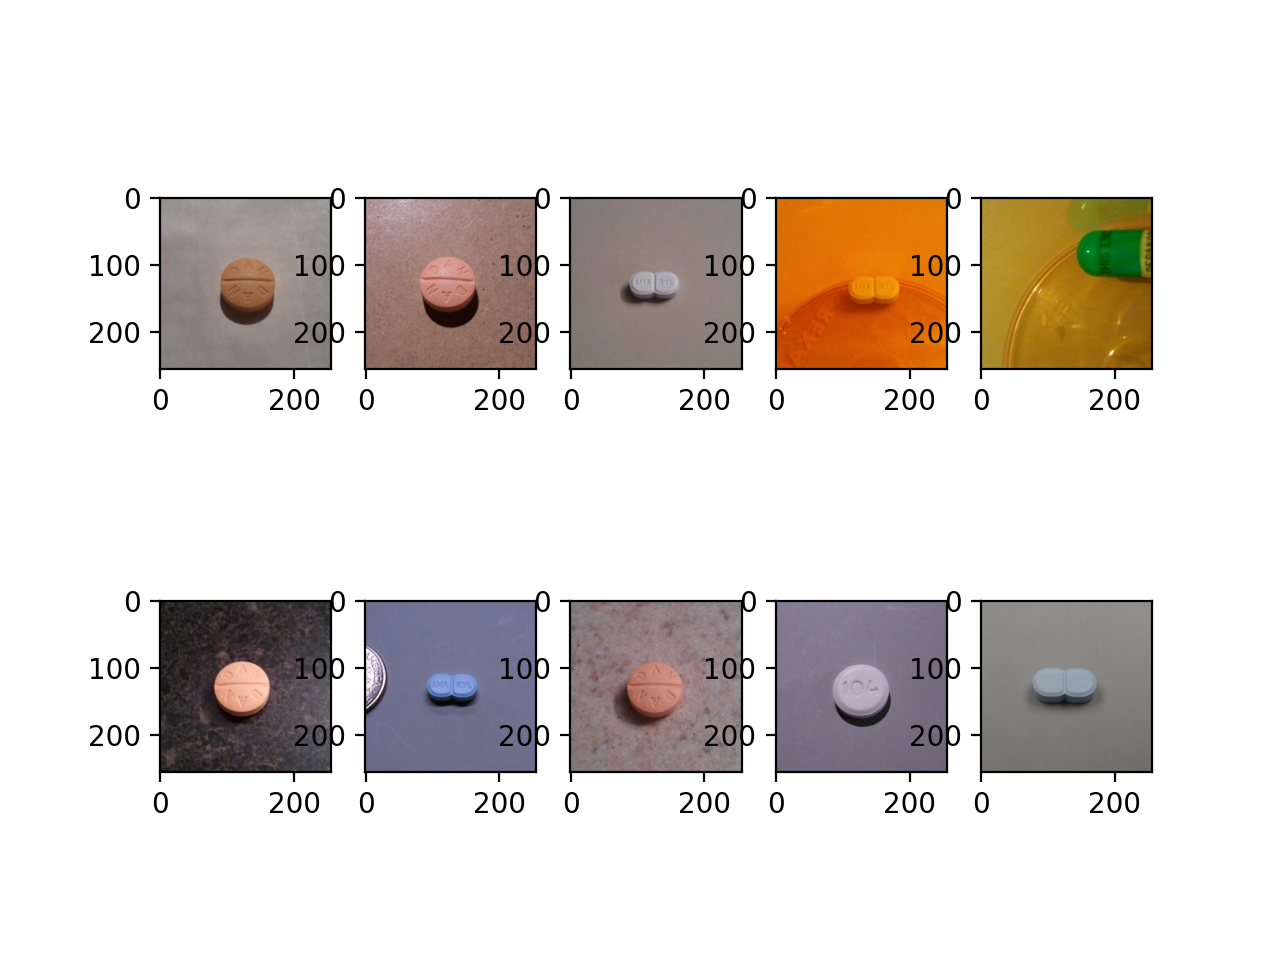

ALLOPURINOL 300MG TABS
[[0 0 1 0 0]]
ALLOPURINOL 300MG TABS
[[0 0 1 0 0]]
AMARYL 4MG TABLETS
[[1 0 0 0 0]]
AMARYL 4MG TABLETS
[[1 0 0 0 0]]
DEPAKOTE SPRINKLES 125 MG
[[0 1 0 0 0]]
ALLOPURINOL 300MG TABS
[[0 0 1 0 0]]
AMARYL 4MG TABLETS
[[1 0 0 0 0]]
ALLOPURINOL 300MG TABS
[[0 0 1 0 0]]
BETHANECHOL TAB 10MG
[[0 0 0 1 0]]
AMARYL 4MG TABLETS
[[1 0 0 0 0]]


In [155]:
images = db.imgs
from matplotlib import pyplot as plt

fig, axs = plt.subplots(2, 5)
idxs = np.arange(427)
np.random.shuffle(idxs)
for i in range(10):
    j = idxs[i]
    axs[i // 5, i % 5].imshow(images[j][0])
    print(images[j][1])
    print(test_one_hot([images[j][1]]))